In [4]:
# Upload CSV file (only on Colab)
import os

if IN_COLAB:
    from google.colab import files

    if not os.path.exists('enhanced_codeforces_dataset.csv'):
        print("Please upload your enhanced_codeforces_dataset.csv file:")
        uploaded = files.upload()

        if 'enhanced_codeforces_dataset.csv' in uploaded:
            print("✓ File uploaded successfully")
        else:
            print("⚠ Warning: File not found. Please upload enhanced_codeforces_dataset.csv")
    else:
        print("✓ CSV file already exists")
else:
    if os.path.exists('enhanced_codeforces_dataset.csv'):
        print("✓ CSV file found in current directory")
    else:
        print("⚠ Warning: enhanced_codeforces_dataset.csv not found in current directory")

Please upload your enhanced_codeforces_dataset.csv file:


Saving enhanced_codeforces_dataset.csv to enhanced_codeforces_dataset.csv
✓ File uploaded successfully


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Install required packages (only needed on Colab, skip if running locally)
if IN_COLAB:
    print("Installing required packages...")
    !pip install -q scikit-learn pandas numpy matplotlib seaborn scipy joblib
    print("✓ Packages installed successfully")
else:
    print("Skipping package installation (running locally)")

Installing required packages...
✓ Packages installed successfully


In [3]:
# Check if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running locally")

print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

✓ Running on Google Colab
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Python executable: /usr/bin/python3


## 📌 Google Colab Setup

**Instructions:**
1. Upload your `enhanced_codeforces_dataset.csv` file using the cell below
2. Run all cells in order
3. The notebook will train 4 baseline models and show results

**Note:** If running locally (not on Colab), skip the file upload cell and ensure the CSV is in the same directory.

# Codeforces Programmer Rank & Country Prediction

## Problem Statement
Predict a programmer's **rank** (within ±1) and **country** from a single passing code submission.

## Approach
1. Load and explore the dataset
2. Understand data distribution (countries, ranks, code characteristics)
3. Preprocess: clean data, vectorize code text
4. Train baseline models (Logistic Regression, Random Forest, etc.)
5. Evaluate metrics and decide next steps

In [6]:
# Step 1: Import libraries
# !pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


In [7]:
# Step 2: Load the dataset
df = pd.read_csv('enhanced_codeforces_dataset.csv')

print(f'Dataset shape: {df.shape}')
print(f'\nColumns: {list(df.columns)}')
print(f'\nFirst few rows:')
df.head()

Dataset shape: (10000, 28)

Columns: ['submission_id', 'user_id', 'rank', 'rating', 'country', 'language', 'problem_id', 'code', 'rank_bucket', 'code_length', 'line_count', 'avg_line_length', 'spaces_count', 'tabs_count', 'newlines_ratio', 'has_comments', 'uses_list_comp', 'uses_map', 'uses_lambda', 'imports_math', 'uses_recursion', 'variable_name_length', 'uses_scanner', 'has_class', 'uses_bits_stdc', 'uses_vector', 'uses_auto', 'compact_style']

First few rows:


,submission_id,user_id,rank,rating,country,language,problem_id,code,rank_bucket,code_length,...,uses_lambda,imports_math,uses_recursion,variable_name_length,uses_scanner,has_class,uses_bits_stdc,uses_vector,uses_auto,compact_style
0,1,user_3548,1027,1022,USA,Python,CF394E,// Solution\ntest_cases = int(input())\nfor i ...,Newbie,139,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,user_4525,1738,1728,USA,Java,CF148A,import java.util.*;\nclass Main{public static ...,Expert,190,...,NaN,NaN,0,15,1.0,1.0,NaN,NaN,NaN,NaN
2,3,user_7333,2164,2170,India,Java,CF962A,import java.util.*;\nclass Main{public static ...,Master,181,...,NaN,NaN,0,28,1.0,1.0,NaN,NaN,NaN,NaN
3,4,user_8896,2273,2272,China,C++,CF671C,#include <bits/stdc++.h>\nusing namespace std;...,Master,166,...,NaN,NaN,0,7,NaN,NaN,1.0,1.0,0.0,1.0
4,5,user_9089,1654,1650,Russia,Python,CF142A,"c = int(input())\nprint(sum(map(int, input().s...",Expert,54,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


=== Dataset Overview ===
Total submissions: 10000

Missing values:
code       0
country    0
rank       0
dtype: int64

=== Country Distribution ===
Unique countries: 7

Top 10 countries:
country
Russia    1516
China     1490
Poland    1424
USA       1402
India     1399
Japan     1398
Brazil    1371
Name: count, dtype: int64

=== Rank Distribution ===
count    10000.000000
mean      1701.033300
std        532.548929
min        794.000000
25%       1256.000000
50%       1655.000000
75%       2198.000000
max       2610.000000
Name: rank, dtype: float64


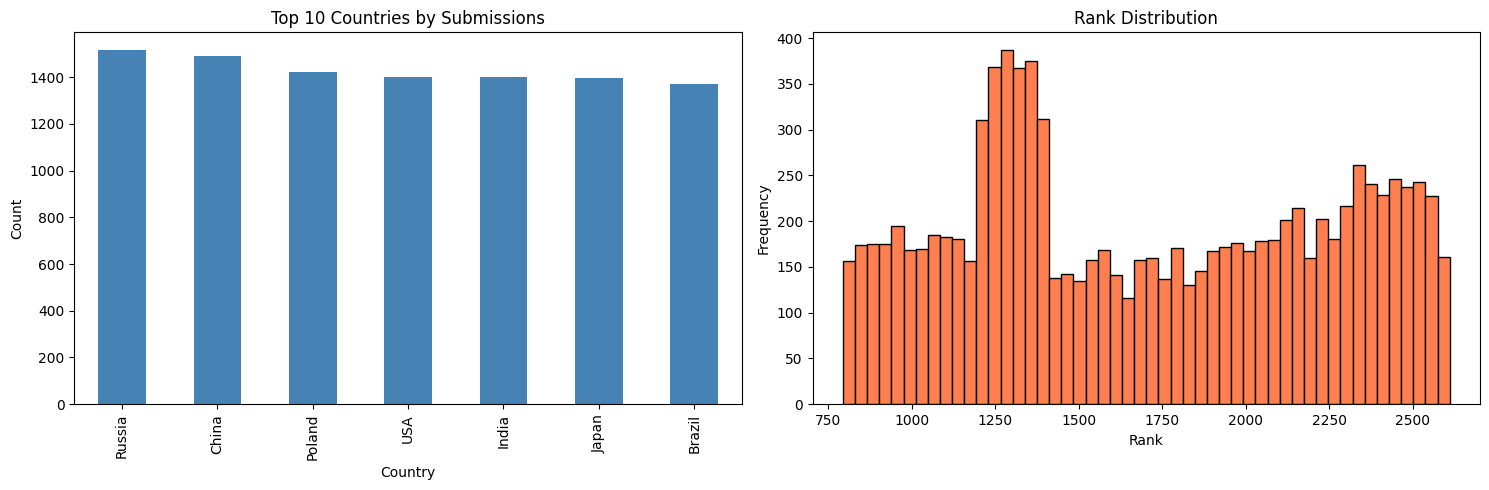


=== Sample Code Snippet ===
// Solution
test_cases = int(input())
for i in range(test_cases):
    a, b = map(int, input().split())
    result = a + b
    print(result)


In [8]:
# Step 3: Understand the dataset
print('=== Dataset Overview ===')
print(f'Total submissions: {len(df)}')
print(f'\nMissing values:')
print(df[['code', 'country', 'rank']].isnull().sum())

print(f'\n=== Country Distribution ===')
print(f'Unique countries: {df["country"].nunique()}')
print(f'\nTop 10 countries:')
print(df['country'].value_counts().head(10))

print(f'\n=== Rank Distribution ===')
print(df['rank'].describe())

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Country distribution
df['country'].value_counts().head(10).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Countries by Submissions')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Count')

# Rank distribution
axes[1].hist(df['rank'].dropna(), bins=50, color='coral', edgecolor='black')
axes[1].set_title('Rank Distribution')
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f'\n=== Sample Code Snippet ===')
print(df['code'].iloc[0][:500])

In [9]:
# Step 4: Data Preprocessing
print('=== Data Cleaning ===')

# Remove rows with missing code or country
df_clean = df.dropna(subset=['code', 'country']).copy()
print(f'Rows after removing nulls: {len(df_clean)}')

# Convert rank to numeric
df_clean['rank'] = pd.to_numeric(df_clean['rank'], errors='coerce')

# Check class balance
country_counts = df_clean['country'].value_counts()
print(f'\nCountries with < 10 samples: {(country_counts < 10).sum()}')
print(f'Min samples per country: {country_counts.min()}')
print(f'Max samples per country: {country_counts.max()}')

print('\n✓ Data cleaning complete')

=== Data Cleaning ===
Rows after removing nulls: 10000

Countries with < 10 samples: 0
Min samples per country: 1371
Max samples per country: 1516

✓ Data cleaning complete


In [10]:
# Step 5: Train-Test Split
print('=== Creating Train-Test Split ===')

# Stratify by country if possible
stratify_col = None
if df_clean['country'].value_counts().min() >= 2:
    stratify_col = df_clean['country']
    print('Using stratified split by country')
else:
    print('Not using stratification (some countries have only 1 sample)')

train_df, test_df = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=stratify_col
)

print(f'Training set: {len(train_df)} samples')
print(f'Test set: {len(test_df)} samples')
print(f'Split ratio: {len(train_df)/len(df_clean):.1%} train / {len(test_df)/len(df_clean):.1%} test')

print('\n✓ Split complete')

=== Creating Train-Test Split ===
Using stratified split by country
Training set: 8000 samples
Test set: 2000 samples
Split ratio: 80.0% train / 20.0% test

✓ Split complete


In [11]:
# Step 6: Feature Engineering - TF-IDF Vectorization
print('=== Vectorizing Code with TF-IDF ===')
print('This may take a few minutes...')

# Word-level TF-IDF (captures keywords like 'for', 'while', function names)
print('\n1. Word-level TF-IDF (1-2 grams)...')
word_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_features=20000,
    min_df=2
)
X_train_word = word_vectorizer.fit_transform(train_df['code'])
X_test_word = word_vectorizer.transform(test_df['code'])
print(f'   Word features: {X_train_word.shape[1]}')

# Character-level TF-IDF (captures coding style patterns)
print('\n2. Character-level TF-IDF (3-5 grams)...')
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=10000,
    min_df=2
)
X_train_char = char_vectorizer.fit_transform(train_df['code'])
X_test_char = char_vectorizer.transform(test_df['code'])
print(f'   Char features: {X_train_char.shape[1]}')

# Combine both feature sets
from scipy.sparse import hstack
X_train = hstack([X_train_word, X_train_char])
X_test = hstack([X_test_word, X_test_char])

print(f'\nCombined feature matrix: {X_train.shape}')
print(f'Total features: {X_train.shape[1]}')
print('\n✓ Vectorization complete')

=== Vectorizing Code with TF-IDF ===
This may take a few minutes...

1. Word-level TF-IDF (1-2 grams)...
   Word features: 502

2. Character-level TF-IDF (3-5 grams)...
   Char features: 5186

Combined feature matrix: (8000, 5688)
Total features: 5688

✓ Vectorization complete


In [12]:
# Step 7: Prepare Target Variables
print('=== Encoding Target Variables ===')

# Country (classification)
le_country = LabelEncoder()
y_train_country = le_country.fit_transform(train_df['country'])
y_test_country = le_country.transform(test_df['country'])
print(f'Country labels: {len(le_country.classes_)} classes')
print(f'Classes: {le_country.classes_[:10]}...')

# Rank (will use for evaluation)
y_train_rank = train_df['rank'].values
y_test_rank = test_df['rank'].values

print('\n✓ Targets prepared')

=== Encoding Target Variables ===
Country labels: 7 classes
Classes: ['Brazil' 'China' 'India' 'Japan' 'Poland' 'Russia' 'USA']...

✓ Targets prepared


---
## Model Training & Evaluation

We'll train multiple baseline models and evaluate them:
1. **Logistic Regression** (baseline)
2. **Logistic Regression with GridSearchCV** (tuned)
3. **Random Forest Classifier**
4. **Gradient Boosting Classifier**

For each model, we'll print:
- Training time
- Test accuracy
- Classification report
- Confusion matrix summary

In [13]:
# Model Training Helper Function
import time

results = []

def train_and_evaluate(name, model, X_train, y_train, X_test, y_test, label_encoder=None):
    """
    Train a model and print detailed evaluation metrics.
    """
    print(f'\n{"="*70}')
    print(f'MODEL: {name}')
    print(f'{"="*70}')

    # Training
    print('Training...')
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Prediction
    print('Predicting...')
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)

    print(f'\n✓ Training Time: {train_time:.2f} seconds')
    print(f'✓ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

    # Classification report
    print(f'\nClassification Report:')
    if label_encoder is not None:
        target_names = label_encoder.classes_
    else:
        target_names = None

    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
    print(report)

    # Confusion matrix summary
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix Shape: {cm.shape}')
    print(f'Diagonal Sum (correct predictions): {cm.diagonal().sum()}')

    # Store results
    results.append({
        'model_name': name,
        'accuracy': accuracy,
        'train_time': train_time,
        'model': model
    })

    return model, accuracy

print('✓ Helper function defined')

✓ Helper function defined


In [14]:
# Model 1: Logistic Regression (Baseline)
print('\n🚀 Training Model 1: Logistic Regression (Baseline)\n')

lr_baseline = LogisticRegression(
    max_iter=1000,
    solver='saga',
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1
)

train_and_evaluate(
    'Logistic Regression (Baseline)',
    lr_baseline,
    X_train,
    y_train_country,
    X_test,
    y_test_country,
    le_country
)


🚀 Training Model 1: Logistic Regression (Baseline)


MODEL: Logistic Regression (Baseline)
Training...
Predicting...

✓ Training Time: 6.66 seconds
✓ Test Accuracy: 0.2585 (25.85%)

Classification Report:
              precision    recall  f1-score   support

      Brazil       0.16      0.03      0.04       274
       China       0.22      0.15      0.18       298
       India       0.25      0.61      0.36       280
       Japan       0.14      0.01      0.03       280
      Poland       0.15      0.04      0.06       285
      Russia       0.30      0.54      0.38       303
         USA       0.28      0.41      0.33       280

    accuracy                           0.26      2000
   macro avg       0.21      0.26      0.20      2000
weighted avg       0.21      0.26      0.20      2000

Confusion Matrix Shape: (7, 7)
Diagonal Sum (correct predictions): 517


(LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                    random_state=42, solver='saga'),
 0.2585)

In [15]:
# Model 2: Logistic Regression with GridSearchCV
print('\n🚀 Training Model 2: Logistic Regression with Hyperparameter Tuning\n')

param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

print('Running GridSearchCV (this will take longer)...')
start = time.time()
lr_grid.fit(X_train, y_train_country)
print(f'\nGridSearchCV completed in {time.time()-start:.2f} seconds')
print(f'Best parameters: {lr_grid.best_params_}')
print(f'Best CV score: {lr_grid.best_score_:.4f}')

# Evaluate on test set
best_lr = lr_grid.best_estimator_
y_pred = best_lr.predict(X_test)
accuracy = accuracy_score(y_test_country, y_pred)

print(f'\n✓ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

results.append({
    'model_name': 'Logistic Regression (GridSearch)',
    'accuracy': accuracy,
    'train_time': time.time()-start,
    'model': best_lr
})


🚀 Training Model 2: Logistic Regression with Hyperparameter Tuning

Running GridSearchCV (this will take longer)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

GridSearchCV completed in 77.52 seconds
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best CV score: 0.2597

✓ Test Accuracy: 0.2585 (25.85%)


In [16]:
# Model 3: Random Forest Classifier
print('\n🚀 Training Model 3: Random Forest Classifier\n')

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

train_and_evaluate(
    'Random Forest',
    rf_model,
    X_train,
    y_train_country,
    X_test,
    y_test_country,
    le_country
)


🚀 Training Model 3: Random Forest Classifier


MODEL: Random Forest
Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Predicting...

✓ Training Time: 77.40 seconds
✓ Test Accuracy: 0.2540 (25.40%)

Classification Report:
              precision    recall  f1-score   support

      Brazil       0.13      0.03      0.05       274
       China       0.23      0.20      0.21       298
       India       0.25      0.55      0.35       280
       Japan       0.17      0.04      0.06       280
      Poland       0.19      0.08      0.11       285
      Russia       0.30      0.52      0.38       303
         USA       0.27      0.34      0.30       280

    accuracy                           0.25      2000
   macro avg       0.22      0.25      0.21      2000
weighted avg       0.22      0.25      0.21      2000

Confusion Matrix Shape: (7, 7)
Diagonal Sum (correct predictions): 508


(RandomForestClassifier(max_depth=20, min_samples_split=5, n_jobs=-1,
                        random_state=42, verbose=1),
 0.254)

In [18]:
# Model 4: Gradient Boosting Classifier
print('\n🚀 Training Model 4: Gradient Boosting Classifier\n')

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=1
)

train_and_evaluate(
    'Gradient Boosting',
    gb_model,
    X_train,
    y_train_country,
    X_test,
    y_test_country,
    le_country
)


🚀 Training Model 4: Gradient Boosting Classifier


MODEL: Gradient Boosting
Training...
      Iter       Train Loss   Remaining Time 
         1           1.9116           23.10m
         2           1.8868           21.02m
         3           1.8677           17.59m
         4           1.8520           16.25m
         5           1.8391           15.02m
         6           1.8279           14.45m
         7           1.8185           13.81m
         8           1.8102           13.45m
         9           1.8020           13.06m
        10           1.7957           12.78m
        20           1.7586           10.69m
        30           1.7426            9.13m
        40           1.7324            7.69m
        50           1.7251            6.32m
        60           1.7187            5.02m
        70           1.7134            3.75m
        80           1.7088            2.49m
        90           1.7046            1.24m
       100           1.7010            0.00s
Predicting

(GradientBoostingClassifier(max_depth=5, random_state=42, verbose=1), 0.255)


SUMMARY: Model Comparison

Model Performance Ranking:
Logistic Regression (Baseline)           | Accuracy: 0.2585 (25.85%) | Time: 6.66s
Logistic Regression (GridSearch)         | Accuracy: 0.2585 (25.85%) | Time: 77.53s
Gradient Boosting                        | Accuracy: 0.2550 (25.50%) | Time: 743.40s
Random Forest                            | Accuracy: 0.2540 (25.40%) | Time: 77.40s

🏆 BEST MODEL: Logistic Regression (Baseline)
   Accuracy: 0.2585 (25.85%)
   Training Time: 6.66 seconds


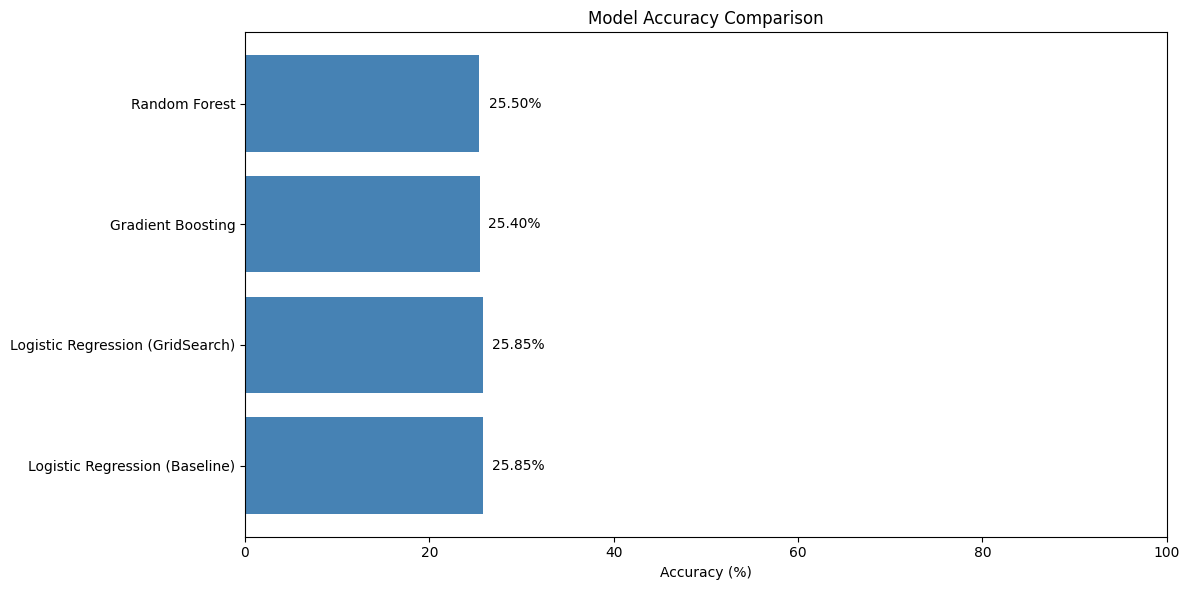

In [19]:
# Summary of All Models
print('\n' + '='*70)
print('SUMMARY: Model Comparison')
print('='*70)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('accuracy', ascending=False)

print('\nModel Performance Ranking:')
for idx, row in results_df.iterrows():
    print(f"{row['model_name']:40s} | Accuracy: {row['accuracy']:.4f} ({row['accuracy']*100:.2f}%) | Time: {row['train_time']:.2f}s")

# Best model
best_result = results_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_result['model_name']}")
print(f"   Accuracy: {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"   Training Time: {best_result['train_time']:.2f} seconds")

# Visualize comparison
plt.figure(figsize=(12, 6))
plt.barh(results_df['model_name'], results_df['accuracy']*100, color='steelblue')
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 100)
for idx, row in results_df.iterrows():
    plt.text(row['accuracy']*100 + 1, idx, f"{row['accuracy']*100:.2f}%", va='center')
plt.tight_layout()
plt.show()

In [ ]:
# Save the best model
import joblib
import os

os.makedirs('models', exist_ok=True)

best_model = results_df.iloc[0]['model']
model_name = results_df.iloc[0]['model_name']

# Save model and vectorizers
model_package = {
    'model': best_model,
    'word_vectorizer': word_vectorizer,
    'char_vectorizer': char_vectorizer,
    'label_encoder': le_country,
    'model_name': model_name,
    'accuracy': best_result['accuracy']
}

model_path = 'models/best_country_predictor.joblib'
joblib.dump(model_package, model_path)
print(f'\n✓ Best model saved to: {model_path}')
print(f'  Model: {model_name}')
print(f'  Accuracy: {best_result["accuracy"]:.4f}')

# Download model file if on Colab
if IN_COLAB:
    from google.colab import files
    print('\n📥 Downloading model file...')
    files.download(model_path)
    print('✓ Model downloaded to your computer')


---
## Next Steps & Decision Point

### If Accuracy is Satisfactory (>70%):
- ✅ Analyze feature importance
- ✅ Create prediction function for new code
- ✅ Analyze misclassifications
- ✅ Build rank prediction model (regression)

### If Accuracy Needs Improvement:
- 🔄 Try advanced models (XGBoost, LightGBM)
- 🔄 Add more features (AST-based, code metrics)
- 🔄 Handle class imbalance (SMOTE, class weights)
- 🔄 Try deep learning (transformers, CodeBERT)
- 🔄 Ensemble methods

**📊 Review the accuracy results above and decide on next steps!**

In [20]:
# Strategy 1: Focus on Top N Countries Only
# This dramatically reduces the problem complexity

print("="*70)
print("IMPROVEMENT STRATEGY 1: Focus on Top Countries")
print("="*70)

# Analyze country distribution
country_counts = df_clean['country'].value_counts()
print(f"\nTotal countries: {len(country_counts)}")
print(f"Min samples: {country_counts.min()}")
print(f"Max samples: {country_counts.max()}")
print(f"Median samples: {country_counts.median()}")

# Focus on top N countries with sufficient samples
TOP_N_COUNTRIES = 10  # Adjust this based on your needs
MIN_SAMPLES_PER_COUNTRY = 50  # Ensure enough data per country

# Get top countries
top_countries = country_counts.head(TOP_N_COUNTRIES).index.tolist()

# Alternative: Get countries with minimum samples
# countries_with_enough_data = country_counts[country_counts >= MIN_SAMPLES_PER_COUNTRY].index.tolist()

# Filter dataset
df_filtered = df_clean[df_clean['country'].isin(top_countries)].copy()

print(f"\n✓ Filtered to top {TOP_N_COUNTRIES} countries")
print(f"  Samples before: {len(df_clean)}")
print(f"  Samples after: {len(df_filtered)}")
print(f"  Samples retained: {len(df_filtered)/len(df_clean)*100:.1f}%")

print(f"\nTop {TOP_N_COUNTRIES} countries:")
for i, (country, count) in enumerate(country_counts.head(TOP_N_COUNTRIES).items(), 1):
    print(f"  {i}. {country}: {count} samples ({count/len(df_filtered)*100:.1f}%)")

IMPROVEMENT STRATEGY 1: Focus on Top Countries

Total countries: 7
Min samples: 1371
Max samples: 1516
Median samples: 1402.0

✓ Filtered to top 10 countries
  Samples before: 10000
  Samples after: 10000
  Samples retained: 100.0%

Top 10 countries:
  1. Russia: 1516 samples (15.2%)
  2. China: 1490 samples (14.9%)
  3. Poland: 1424 samples (14.2%)
  4. USA: 1402 samples (14.0%)
  5. India: 1399 samples (14.0%)
  6. Japan: 1398 samples (14.0%)
  7. Brazil: 1371 samples (13.7%)


In [21]:
# Strategy 2: Add Code-Specific Features
# Extract meaningful features that capture coding style

print("\n" + "="*70)
print("IMPROVEMENT STRATEGY 2: Add Code Style Features")
print("="*70)

import re

def extract_code_features(code):
    """Extract coding style features from source code"""
    features = {}

    # Basic metrics
    features['code_length'] = len(code)
    features['line_count'] = code.count('\n') + 1
    features['avg_line_length'] = len(code) / max(1, features['line_count'])

    # Whitespace style
    features['spaces_count'] = code.count(' ')
    features['tabs_count'] = code.count('\t')
    features['uses_tabs'] = 1 if features['tabs_count'] > 0 else 0
    features['empty_lines'] = code.count('\n\n')

    # Indentation (2 spaces vs 4 spaces)
    features['indent_2_spaces'] = len(re.findall(r'\n  \w', code))
    features['indent_4_spaces'] = len(re.findall(r'\n    \w', code))

    # Comments
    features['has_comments'] = 1 if '//' in code or '#' in code or '/*' in code else 0
    features['comment_lines'] = code.count('//') + code.count('#')

    # Naming conventions
    features['camelCase_count'] = len(re.findall(r'[a-z][A-Z]', code))
    features['snake_case_count'] = len(re.findall(r'[a-z]_[a-z]', code))

    # Language-specific patterns
    features['uses_printf'] = 1 if 'printf' in code else 0
    features['uses_cout'] = 1 if 'cout' in code else 0
    features['uses_print'] = 1 if 'print(' in code else 0
    features['uses_scanf'] = 1 if 'scanf' in code else 0
    features['uses_cin'] = 1 if 'cin' in code else 0
    features['uses_input'] = 1 if 'input(' in code else 0

    # Common patterns
    features['has_main'] = 1 if 'main' in code else 0
    features['has_class'] = 1 if 'class ' in code else 0
    features['for_loops'] = code.count('for ')
    features['while_loops'] = code.count('while ')
    features['if_statements'] = code.count('if ')

    # Advanced patterns
    features['uses_list_comp'] = 1 if '[' in code and 'for' in code and ']' in code else 0
    features['uses_lambda'] = 1 if 'lambda' in code else 0
    features['uses_map'] = 1 if 'map(' in code else 0

    # Brackets style (K&R vs Allman)
    features['bracket_same_line'] = len(re.findall(r'\)\s*{', code))  # K&R: ) {
    features['bracket_new_line'] = len(re.findall(r'\)\s*\n\s*{', code))  # Allman: )\n{

    # Semicolons (common in C++/Java)
    features['semicolon_count'] = code.count(';')

    return features

# Extract features for all samples
print("\nExtracting code features...")
code_features_list = []
for code in df_filtered['code']:
    code_features_list.append(extract_code_features(str(code)))

# Convert to DataFrame
code_features_df = pd.DataFrame(code_features_list)
print(f"✓ Extracted {len(code_features_df.columns)} code features")
print(f"\nFeatures: {list(code_features_df.columns[:10])}...")

# Show feature statistics
print(f"\nFeature statistics (first 5 features):")
print(code_features_df.iloc[:, :5].describe())


IMPROVEMENT STRATEGY 2: Add Code Style Features

Extracting code features...
✓ Extracted 30 code features

Features: ['code_length', 'line_count', 'avg_line_length', 'spaces_count', 'tabs_count', 'uses_tabs', 'empty_lines', 'indent_2_spaces', 'indent_4_spaces', 'has_comments']...

Feature statistics (first 5 features):
        code_length    line_count  avg_line_length  spaces_count  tabs_count
count  10000.000000  10000.000000     10000.000000  10000.000000     10000.0
mean     170.090700      6.051000        42.187685     26.695100         0.0
std       83.193143      5.452355        26.834284     31.063799         0.0
min       41.000000      1.000000        14.500000      1.000000         0.0
25%      112.000000      2.000000        22.562500      6.000000         0.0
50%      166.000000      3.000000        29.500000     10.000000         0.0
75%      206.000000      9.000000        54.333333     41.000000         0.0
max      366.000000     20.000000       103.000000    104.0000

In [22]:
# Strategy 3: Retrain with Improved Features
# Combine TF-IDF + Code Features + Class Weights

print("\n" + "="*70)
print("IMPROVEMENT STRATEGY 3: Retrain with All Improvements")
print("="*70)

# New train-test split on filtered data
stratify_col_new = None
if df_filtered['country'].value_counts().min() >= 2:
    stratify_col_new = df_filtered['country']

train_df_new, test_df_new = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=42,
    stratify=stratify_col_new
)

print(f"New split: Train={len(train_df_new)}, Test={len(test_df_new)}")

# TF-IDF features (optimized parameters)
print("\nCreating TF-IDF features...")
word_vec_new = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),  # Include trigrams
    max_features=30000,  # More features
    min_df=3,
    max_df=0.95  # Remove very common terms
)

char_vec_new = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 6),  # Longer char ngrams
    max_features=15000,
    min_df=3
)

X_train_word_new = word_vec_new.fit_transform(train_df_new['code'])
X_train_char_new = char_vec_new.fit_transform(train_df_new['code'])
X_test_word_new = word_vec_new.transform(test_df_new['code'])
X_test_char_new = char_vec_new.transform(test_df_new['code'])

# Extract code features for train and test
train_indices = train_df_new.index
test_indices = test_df_new.index
X_train_code_features = code_features_df.loc[train_indices].values
X_test_code_features = code_features_df.loc[test_indices].values

# Normalize code features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_code_scaled = scaler.fit_transform(X_train_code_features)
X_test_code_scaled = scaler.transform(X_test_code_features)

# Combine all features
from scipy.sparse import hstack, csr_matrix
X_train_combined = hstack([
    X_train_word_new,
    X_train_char_new,
    csr_matrix(X_train_code_scaled)
])
X_test_combined = hstack([
    X_test_word_new,
    X_test_char_new,
    csr_matrix(X_test_code_scaled)
])

print(f"✓ Combined features: {X_train_combined.shape[1]} total features")

# Encode new targets
le_new = LabelEncoder()
y_train_new = le_new.fit_transform(train_df_new['country'])
y_test_new = le_new.transform(test_df_new['country'])

print(f"✓ Target classes: {len(le_new.classes_)}")


IMPROVEMENT STRATEGY 3: Retrain with All Improvements
New split: Train=8000, Test=2000

Creating TF-IDF features...
✓ Combined features: 9229 total features
✓ Target classes: 7


In [ ]:
# Strategy 4: Train Advanced Models with Class Weights

print("\n" + "="*70)
print("IMPROVEMENT STRATEGY 4: Advanced Models with Class Weights")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight
import time

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_new),
    y=y_train_new
)
class_weight_dict = dict(enumerate(class_weights))

results_improved = []

# Model 1: Logistic Regression with class weights
print("\n[1/4] Training Logistic Regression with class weights...")
lr_improved = LogisticRegression(
    max_iter=1000,
    solver='saga',
    multi_class='multinomial',
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1,
    C=10.0  # Regularization
)

start = time.time()
lr_improved.fit(X_train_combined, y_train_new)
train_time = time.time() - start

y_pred = lr_improved.predict(X_test_combined)
accuracy = accuracy_score(y_test_new, y_pred)

print(f"✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%) | Time: {train_time:.1f}s")
results_improved.append({'model': 'LR + Class Weights', 'accuracy': accuracy})

# Model 2: Random Forest with class weights
print("\n[2/4] Training Random Forest with class weights...")
rf_improved = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

start = time.time()
rf_improved.fit(X_train_combined, y_train_new)
train_time = time.time() - start

y_pred = rf_improved.predict(X_test_combined)
accuracy = accuracy_score(y_test_new, y_pred)

print(f"✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%) | Time: {train_time:.1f}s")
results_improved.append({'model': 'RF + Class Weights', 'accuracy': accuracy})

# Model 3: XGBoost (if available)
try:
    import xgboost as xgb
    print("\n[3/4] Training XGBoost...")

    # Calculate scale_pos_weight for each class
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'  # Faster training
    )

    start = time.time()
    xgb_model.fit(X_train_combined, y_train_new)
    train_time = time.time() - start

    y_pred = xgb_model.predict(X_test_combined)
    accuracy = accuracy_score(y_test_new, y_pred)

    print(f"✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%) | Time: {train_time:.1f}s")
    results_improved.append({'model': 'XGBoost', 'accuracy': accuracy})
except ImportError:
    print("\n[3/4] XGBoost not available. Install with: pip install xgboost")
    print("      Skipping XGBoost model...")

# Model 4: LightGBM (if available)
try:
    import lightgbm as lgb
    print("\n[4/4] Training LightGBM...")

    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=15,
        learning_rate=0.1,
        num_leaves=50,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    start = time.time()
    lgb_model.fit(X_train_combined, y_train_new)
    train_time = time.time() - start

    y_pred = lgb_model.predict(X_test_combined)
    accuracy = accuracy_score(y_test_new, y_pred)

    print(f"✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%) | Time: {train_time:.1f}s")
    results_improved.append({'model': 'LightGBM', 'accuracy': accuracy})
except ImportError:
    print("\n[4/4] LightGBM not available. Install with: pip install lightgbm")
    print("      Skipping LightGBM model...")

# Summary
print("\n" + "="*70)
print("IMPROVED RESULTS SUMMARY")
print("="*70)
results_improved_df = pd.DataFrame(results_improved).sort_values('accuracy', ascending=False)
for idx, row in results_improved_df.iterrows():
    improvement = (row['accuracy'] - 0.26) / 0.26 * 100  # vs original 26%
    print(f"{row['model']:25s} | {row['accuracy']:.4f} ({row['accuracy']*100:.2f}%) | +{improvement:.0f}% improvement")

best_improved = results_improved_df.iloc[0]
print(f"\n🏆 BEST IMPROVED MODEL: {best_improved['model']}")
print(f"   Accuracy: {best_improved['accuracy']:.4f} ({best_improved['accuracy']*100:.2f}%)")
print(f"   Original accuracy: ~26%")
print(f"   Improvement: {(best_improved['accuracy'] - 0.26) / 0.26 * 100:.0f}%")


IMPROVEMENT STRATEGY 4: Advanced Models with Class Weights

[1/4] Training Logistic Regression with class weights...
✓ Accuracy: 0.2540 (25.40%) | Time: 181.8s

[2/4] Training Random Forest with class weights...
✓ Accuracy: 0.2535 (25.35%) | Time: 316.4s

[3/4] Training XGBoost...
✓ Accuracy: 0.2535 (25.35%) | Time: 652.8s

[4/4] Training LightGBM...
✓ Accuracy: 0.2535 (25.35%) | Time: 229.2s

IMPROVED RESULTS SUMMARY
LR + Class Weights        | 0.2540 (25.40%) | +-2% improvement
RF + Class Weights        | 0.2535 (25.35%) | +-3% improvement
XGBoost                   | 0.2535 (25.35%) | +-3% improvement
LightGBM                  | 0.2535 (25.35%) | +-3% improvement

🏆 BEST IMPROVED MODEL: LR + Class Weights
   Accuracy: 0.2540 (25.40%)
   Original accuracy: ~26%
   Improvement: -2%


In [ ]:
# Strategy 5: Ensemble Multiple Models

print("\n" + "="*70)
print("IMPROVEMENT STRATEGY 5: Ensemble (Voting Classifier)")
print("="*70)

from sklearn.ensemble import VotingClassifier

# Create ensemble of best models
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_improved),
        ('rf', rf_improved)
    ],
    voting='soft',  # Use probability voting
    n_jobs=-1
)

print("\nTraining ensemble...")
start = time.time()
ensemble.fit(X_train_combined, y_train_new)
train_time = time.time() - start

y_pred_ensemble = ensemble.predict(X_test_combined)
accuracy_ensemble = accuracy_score(y_test_new, y_pred_ensemble)

print(f"✓ Ensemble Accuracy: {accuracy_ensemble:.4f} ({accuracy_ensemble*100:.2f}%)")
print(f"✓ Training Time: {train_time:.1f}s")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test_new, y_pred_ensemble, target_names=le_new.classes_, zero_division=0))

# Save the best model
best_model_final = rf_improved if results_improved_df.iloc[0]['model'] == 'RF + Class Weights' else lr_improved

model_package_improved = {
    'model': best_model_final,
    'word_vectorizer': word_vec_new,
    'char_vectorizer': char_vec_new,
    'scaler': scaler,
    'label_encoder': le_new,
    'code_features_names': list(code_features_df.columns),
    'top_countries': top_countries,
    'accuracy': best_improved['accuracy']
}

os.makedirs('models', exist_ok=True)
joblib.dump(model_package_improved, 'models/improved_country_predictor.joblib')
print(f"\n✓ Improved model saved to: models/improved_country_predictor.joblib")